# Plot geopandas geometries faster with numpy, descartes, and matplotlib

It's slow to plot thousands of GeoDataFrame rows. Instead, use the speed advantages of numpy, descartes, and matplotlib's API (including its powerful *collections*). I'll use a randomly-generated set of spatial data to demonstrate.

In [1]:
import geopandas as gpd, numpy as np, matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
from shapely.geometry import Point
%matplotlib inline

In [2]:
# create a geopandas GeoDataFrame with 10,000 random points
n = 10000
np.random.seed(1)
x = np.random.random(n)
y = np.random.random(n)
points = [Point(xy) for xy in zip(x, y)]
gdf = gpd.GeoDataFrame({'geometry':points})
gdf.head()

,geometry
0,POINT (0.417022004702574 0.7654969604694121)
1,POINT (0.7203244934421581 0.3081727716820197)
2,POINT (0.0001143748173448866 0.7353778827811243)
3,POINT (0.3023325726318398 0.8121984030110777)
4,POINT (0.146755890817113 0.2366943252343628)


## Demonstrate geopandas point scatter-plotting, vs using numpy and matplotlib

Natively, geopandas treats each row as its own entity, and plots the features one at a time.

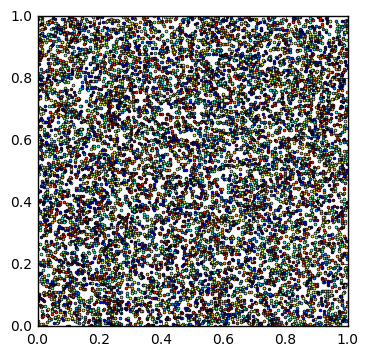

In [3]:
# this is painfully slow
gdf.plot()
plt.show()

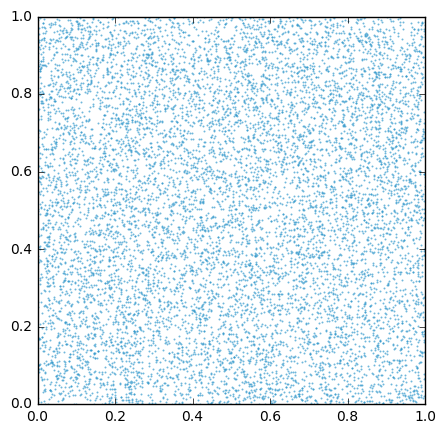

In [4]:
# instead, extract coordinates into separate numpy arrays...
xy = gdf['geometry'].map(lambda point: point.xy)
x, y = zip(*xy)

# ...and then scatter plot with a single call to matplotlib
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x=x, y=y, s=2, color='#3399cc', linewidth=0, alpha=0.7)
ax.set_xlim((0,1))
ax.set_ylim((0,1))
plt.show()

That was fast!

## Time the two methods to demonstrate the speed improvement

In [5]:
def plot1(gdf):
    gdf.plot()
    plt.close()
    
%timeit plot1(gdf)

1 loop, best of 3: 11.9 s per loop


In [6]:
def plot2(gdf):
    xy = gdf['geometry'].map(lambda point: point.xy)
    x, y = zip(*xy)
    fig, ax = plt.subplots()
    ax.scatter(x=x, y=y)
    plt.close()

%timeit plot2(gdf)

1 loop, best of 3: 252 ms per loop


The first technique plots 10,000 points in about 11 seconds, the latter takes about 270 milliseconds.

## Demonstrate faster polygon plotting

In [7]:
# take the first 1,000 points and turn them into polygons
gdf_polygons = gpd.GeoDataFrame(gdf.head(1000).copy())
gdf_polygons['geometry'] = gdf_polygons['geometry'].buffer(0.1)
gdf_polygons.head()

,geometry
0,POLYGON ((0.517022004702574 0.7654969604694121...
1,POLYGON ((0.8203244934421581 0.308172771682019...
2,POLYGON ((0.1001143748173449 0.735377882781124...
3,POLYGON ((0.4023325726318397 0.812198403011077...
4,POLYGON ((0.246755890817113 0.2366943252343628...


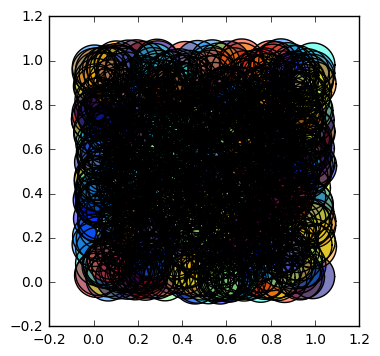

In [8]:
# this is painfully slow
gdf_polygons.plot()
plt.show()

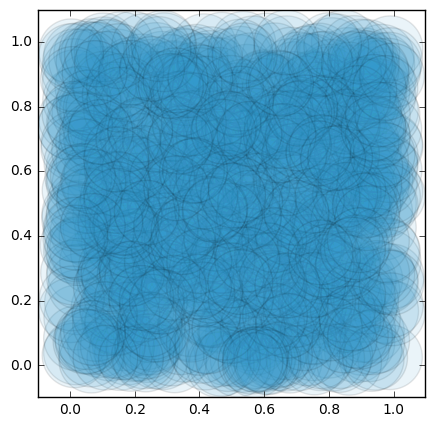

In [9]:
# instead, extract each polygon as a descartes patch, and add to a matplotlib patch collection...
# note, this code assumes all geometries are Polygons - if you have MultiPolygons, handle separately
patches = [PolygonPatch(geometry) for geometry in gdf_polygons['geometry']]
pc = PatchCollection(patches, facecolor='#3399cc', linewidth=1, alpha=0.1)
fig, ax = plt.subplots(figsize=(5,5))
ax.add_collection(pc)

# ...then set the figure bounds to the polygons' bounds
left, bottom, right, top = gdf_polygons.total_bounds
ax.set_xlim((left,right))
ax.set_ylim((bottom,top))
plt.show()

That was fast!

## Time the two methods to demonstrate the speed improvement

In [10]:
def plot_polygons1(gdf_polygons):
    gdf_polygons.plot()
    plt.close()
    
%timeit plot_polygons1(gdf_polygons)

1 loop, best of 3: 2.09 s per loop


In [11]:
def plot_polygons2(gdf_polygons):
    patches = [PolygonPatch(geometry) for geometry in gdf_polygons['geometry']]
    pc = PatchCollection(patches, facecolor='#3399cc', linewidth=0.2, alpha=0.3)
    fig, ax = plt.subplots(figsize=(5,5))
    ax.add_collection(pc)
    plt.close()

%timeit plot_polygons2(gdf_polygons)

1 loop, best of 3: 328 ms per loop


The first technique plots 1,000 polygons in about 2 seconds, the latter takes about 330 milliseconds.